# Racing Analysis

In [19]:
from capo.load_datasets import get_tasks
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [41]:
path = "../results/gsm8k/llama/CAPO/seed44/benchmark_experiment_gsm8k_llama_CAPO_44/fkjd/"
df_eval = pd.read_csv(path + "step_results_eval.csv")
df_blocks = pd.read_parquet(path + "prompt_scores.parquet").reset_index()
df_blocks["prompt"] = df_blocks["index"]
args = pd.read_json(path + "args.json", typ="series")

In [ ]:
task, _, _ = get_tasks(
    dataset_name=args.dataset,
    optimizer_name=args.optimizer,
    seed=args.random_seed,
    block_size=30,
)

init_prompts = task.initial_prompts;

# Calculate saved evaluations

In [ ]:
df_blocks["evaluated_blocks"].sum()

263

In [61]:
len(df_blocks) * 10

540

## Initial Prompts Analysis

In [43]:
df_eval["contains_init"] = df_eval["prompt"].apply(
    lambda x: any([prompt in x for prompt in init_prompts])
)

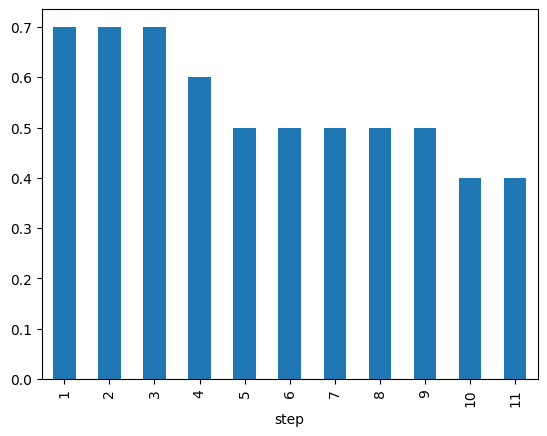

In [44]:
df_eval.groupby("step").mean(numeric_only=True)["contains_init"].plot(kind="bar");

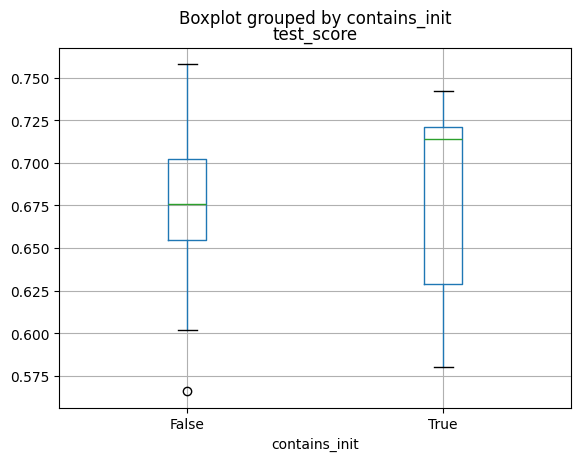

In [45]:
if df_eval is not None:
    df_eval["contains_init"] = df_eval["prompt"].apply(
        lambda x: any([prompt in x for prompt in init_prompts])
    )
    df_eval.groupby("prompt").first().boxplot(column="test_score", by="contains_init")
    df_eval[df_eval["contains_init"]].groupby("prompt", as_index=False).mean(numeric_only=True)[
        ["prompt", "test_score"]
    ].sort_values("test_score", ascending=False)

## Prompt Survival Analysis

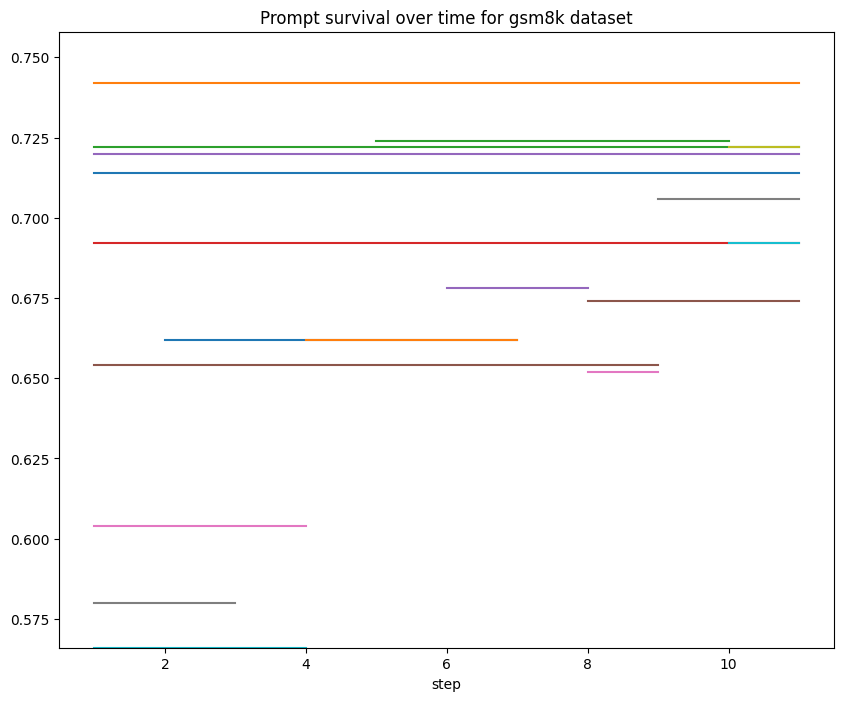

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
for prompt in df_eval["prompt"].unique():
    df_eval[df_eval["prompt"] == prompt].plot(
        x="step", y="test_score", ax=ax
    )  # <-- changed to test_score
ax.get_legend().remove()
ax.set_ylim(min(df_eval["test_score"]), max(df_eval["test_score"]))  # <-- changed to test_score
ax.set_title(f"Prompt survival over time for {args.dataset} dataset")
plt.show()

## Block Score Analysis

In [47]:
df_eval["prompt_short"] = df_eval["prompt"].apply(lambda x: " ".join(x.split()[:20]))

In [48]:
df_blocks["evaluated_blocks"] = 10 - df_blocks.isnull().sum(axis=1)

In [49]:
df_blocks

,index,0,1,2,3,4,5,6,7,8,9,prompt,evaluated_blocks
0,Analyze and solve the following elementary sch...,0.666667,0.733333,0.866667,0.633333,0.800000,0.700000,0.666667,0.766667,0.700000,0.600000,Analyze and solve the following elementary sch...,10
1,Assistance is needed to tackle a challenging e...,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assistance is needed to tackle a challenging e...,1
2,Break down and resolve the given math word pro...,0.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Break down and resolve the given math word pro...,1
3,Break down and resolve the given math word pro...,0.500000,0.800000,0.800000,0.466667,0.666667,0.633333,0.533333,0.600000,NaN,NaN,Break down and resolve the given math word pro...,8
4,Break down and resolve the provided math word ...,0.666667,0.766667,0.900000,0.633333,0.800000,0.800000,0.666667,0.700000,0.766667,0.633333,Break down and resolve the provided math word ...,10
5,Break down this word problem carefully. Rememb...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Break down this word problem carefully. Rememb...,1
6,Calling all math wizards! I need help with thi...,0.733333,0.833333,0.866667,0.600000,0.866667,0.766667,0.766667,0.666667,0.766667,0.700000,Calling all math wizards! I need help with thi...,10
7,Get ready to unleash your math skills on a cha...,0.566667,0.633333,0.766667,0.466667,0.766667,0.733333,0.666667,0.700000,NaN,NaN,Get ready to unleash your math skills on a cha...,8
8,Help me tackle a challenging elementary school...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Help me tackle a challenging elementary school...,1
9,Help me tackle a challenging elementary school...,0.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Help me tackle a challenging elementary school...,1


In [54]:
df_with_blocks = df_blocks.merge(df_eval.groupby("prompt").last(), on=["prompt"], how="right")
df_with_blocks

,index,0,1,2,3,4,5,6,7,8,...,timestamp,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,contains_init,prompt_short
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 20:57:14.877827,372.453011,0.713333,1665,796,272898,81306,0.654,True,Analyze and solve the following elementary sch...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 21:16:03.090275,492.184471,0.733333,1666,748,378054,102994,0.692,False,Break down and resolve the provided math word ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 21:16:03.090275,492.184471,0.756667,1666,748,378054,102994,0.722,True,Calling all math wizards! I need help with thi...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 20:02:00.797319,2371.859177,0.662500,1344,493,1867624,584105,0.602,False,Get ready to unleash your math skills on a cha...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 20:10:52.000227,224.328697,0.633333,1590,695,133787,60138,0.566,False,I need help breaking down and solving a comple...
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 21:16:03.090275,492.184471,0.810000,1666,748,378054,102994,0.714,True,I'd appreciate your assistance with this eleme...
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 20:40:54.515025,542.144447,0.703333,1794,814,360743,151828,0.662,False,I'm having trouble with a complex math word pr...
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 21:16:03.090275,492.184471,0.796667,1666,748,378054,102994,0.742,True,I'm having trouble with this grade school math...
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 21:16:03.090275,492.184471,0.766667,1666,748,378054,102994,0.706,False,I'm in need of a skilled math problem-solver t...
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-03-21 20:40:54.515025,542.144447,0.696667,1794,814,360743,151828,0.662,False,I'm in need of help with solving a math word p...


In [56]:
# do the same with plotly
fig = px.line(
    df_with_blocks,
    x="step",
    y="test_score",  # <--
    color="prompt",
    custom_data=[df_with_blocks["prompt_short"], df_with_blocks["evaluated_blocks"]],
)
fig.update_xaxes(title="step")
fig.update_layout(title=f"Prompt survival over time for {args.dataset} dataset")

# # do not show the legend
fig.update_layout(showlegend=False, height=800)

# # show prompt_short instead of prompt in the hover
fig.update_traces(
    hovertemplate="prompt: %{customdata[0]}<br>score: %{y}<br>test score:%{customdata[2]}<br>evaluated blocks:%{customdata[1]}",
    name="",
)
fig.show()